<a href="https://drive.google.com/drive/folders/176VLvhLVMz4-ZFKh1uHpCijZJfQWd-6w?usp=sharing">Link to the dataset</a>


# 1. Data cleaning 

In [1]:
import pandas as pd
import numpy as np
import warnings
# suppress the warning caused by setting the first column as index column
warnings.simplefilter(action='ignore', category=FutureWarning) 
data = pd.read_csv('cic2017-ddos-data.csv', index_col=0, header=0)
# dataset contains infinite values in some columns
data = data.replace('inf', np.inf)
print('Label column information:')
print(data.loc[:, 'Label'].describe())
data = data.replace(np.nan, np.inf)
data['Flow Bytes/s'].replace(np.inf, data['Flow Bytes/s'].median(), inplace=True)
data['Flow Packets/s'].replace(np.inf, data['Flow Packets/s'].median(), inplace=True)

Label column information:
count     755663
unique         2
top       BENIGN
freq      627636
Name: Label, dtype: object


# 2. Data preprocessing

In [2]:
print('Number of matching values of two columns \"Fwd Header Length\" and \"Fwd Header Length - dupl\": {}'.format(data['Fwd Header Length'].eq(data['Fwd Header Length - dupl']).sum()))
# drop two duplicated columns
data = data.drop(['Fwd Header Length - dupl'], axis=1)
print('Dataset after dropping duplicated column: ')
print('Number of instances = {}'.format(data.shape[0]))
print('Number of attributes = {}'.format(data.shape[1]))

Number of matching values of two columns "Fwd Header Length" and "Fwd Header Length - dupl": 755663
Dataset after dropping duplicated column: 
Number of instances = 755663
Number of attributes = 84


In [3]:
from sklearn.decomposition import PCA

numInstances = data.shape[0]
numComponents = 10
pca = PCA(n_components=numComponents)
pca.fit(data.loc[:, 'Flow Duration':'Idle Min'])

projected = pca.transform(data.loc[:, 'Flow Duration':'Idle Min'])
projected = pd.DataFrame(projected,columns=['PC1','PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], index=range(numInstances))

new = pd.concat([data.iloc[:, 0:7], projected, data.iloc[:, 83]], axis=1)


# 3. Data mining
## Decision tree

### Cross validation without PCA

Text(0, 0.5, 'Accuracy')

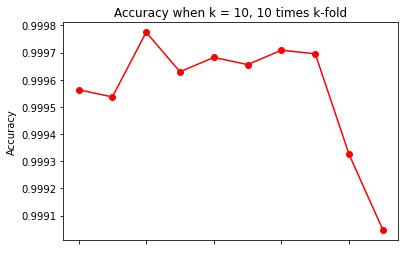

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plot

y = data.loc[:, 'Label']
x = data.drop(['Label'], axis=1)
maxDepth = 5
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxDepth)
# k-fold 10 times, k = 10
scores10 = cross_val_score(clf, x.loc[: , 'Flow Duration':'Idle Min'], y, scoring='accuracy', cv=10)
plot.title('Accuracy when k = 10, 10 times k-fold')
plot.plot(scores10, 'ro-')
plot.xticks(color='w')
plot.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

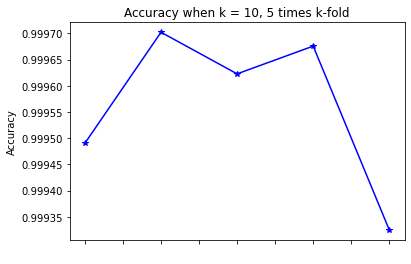

In [5]:
# k-fold 5 times, k = 10
scores5 = cross_val_score(clf, x.loc[: , 'Flow Duration':'Idle Min'], y, scoring='accuracy', cv=5)
plot.title('Accuracy when k = 10, 5 times k-fold')
plot.plot(scores5, 'b*-')
plot.xticks(color='w')
plot.ylabel("Accuracy")

### Cross validation with PCA

Text(0, 0.5, 'Accuracy')

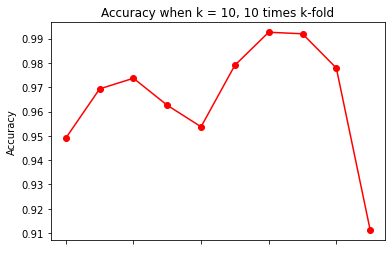

In [6]:
y = new.loc[:, 'Label']
x = new.drop(['Label'], axis=1)
# k-fold 10 times, k = 10
scores10 = cross_val_score(clf, x.loc[: , 'PC1':'PC10'], y, scoring='accuracy', cv=10)
plot.title('Accuracy when k = 10, 10 times k-fold')
plot.plot(scores10, 'ro-')
plot.xticks(color='w')
plot.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

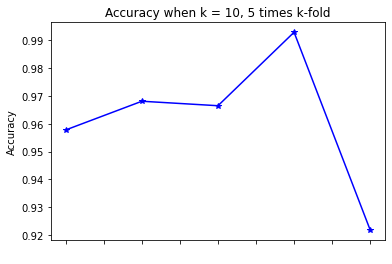

In [7]:
# k-fold 5 times, k = 10
scores5 = cross_val_score(clf, x.loc[: , 'PC1':'PC10'], y, scoring='accuracy', cv=5)
plot.title('Accuracy when k = 10, 5 times k-fold')
plot.plot(scores5, 'b*-')
plot.xticks(color='w')
plot.ylabel("Accuracy")

CV = 3 : [0.96228085 0.96989138 0.94579712]
CV = 4 : [0.96187194 0.96053802 0.98769824 0.93072017]
CV = 5 : [0.95777229 0.96806124 0.96645339 0.99281423 0.92189609]
CV = 6 : [0.95475767 0.97249571 0.9559725  0.98481071 0.99201232 0.90747402]


Text(0, 0.5, 'Accuracy')

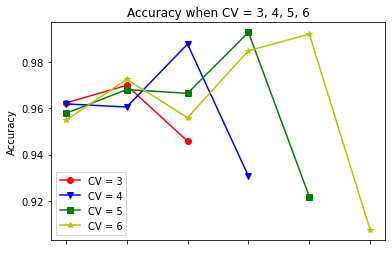

In [8]:
score = []
for i in range(3, 7):
    score.append(cross_val_score(clf, x.loc[: , 'PC1':'PC10'], y, scoring='accuracy', cv=i))
    print('CV = {} : {}'.format(i, score[i - 3]))

plot.plot(score[0], 'ro-', score[1], 'bv-', score[2], 'gs-', score[3], 'y*-')
plot.title('Accuracy when CV = 3, 4, 5, 6')
plot.legend(['CV = 3', 'CV = 4', 'CV = 5', 'CV = 6'])
plot.xticks(color='w')
plot.ylabel('Accuracy')